In [1]:
!pip install praw pandas seaborn scipy nltk scikit-learn spacy polars

In [2]:
import csv
import datetime
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import praw
import prawcore
import random
import seaborn as sns
import time
from typing import Callable

from config import Config, CONFIG_FILE_NAME
from util import *
import validate

sns.set_theme()

In [3]:
# To ensure everything's nice and deterministic
random.seed(0)
np.random.seed(0)

In [4]:
import logging

# This will log everything
LOG = True
if LOG:
    handler = logging.StreamHandler()
    handler.setLevel(logging.WARN)
    for logger_name in ("praw", "prawcore"):
        logger = logging.getLogger(logger_name)
        logger.setLevel(logging.DEBUG)
        logger.addHandler(handler)

In [5]:
# Create the Reddit instance to do all the API stuff with
reddit = init_reddit()

Version 7.7.1 of praw is outdated. Version 7.8.1 was released Friday October 25, 2024.


In [6]:
keywords = [
    r"trauma",
    r"gaslight",
    r"trigger",
    r"toxic",
    r"manipulat",
    r"microaggression",
    r"autis",
    r"adhd",
    r"ocd",
    r"ptsd",
    r"bipolar",
    r"anxiety",
    r"depress",
    r"psycho",
    r"delusion",
    r"addict",
    r"abus",
    r"unstable",
    r"narcissis",
    r"addict",
    r"neurodivergen",
]

In [7]:
first_id = int("c000000", 36)  # todo find the ID of the first post we want to analyze
# Earliest post I can find: https://www.reddit.com/api/info.json?id=t1_c015001
last_id = int("l000000", 36)  # todo find the ID of the last post we want to analyze

## Load comments

In [8]:
df, misses = load_data()
df

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
0,26151741276,2010-01-01 21:35:21,WTF,NaN,26151716521,17754997,6,0,because video games are clearly evil
1,26151810869,2010-01-02 19:53:53,funny,6.163154e+06,26151783720,17767506,5,0,"In this country, due to a crazy statutory syst..."
2,26151877505,2010-01-03 16:50:10,AskReddit,5.173746e+06,26151775464,17764325,2,0,Another [fun fact](http://en.wikipedia.org/wik...
3,26151961856,2010-01-04 14:49:44,politics,5.338134e+06,63325885185,17798913,1,0,It would serve that ltwo-faced ying Fraud righ...
4,26152018319,2010-01-05 04:01:25,AskReddit,NaN,26152018037,17808899,1,0,Thanks for your response. And I agree with you...
...,...,...,...,...,...,...,...,...,...
11398,44474899942,2023-12-30 03:37:21,EscapingPrisonPlanet,NaN,44474892938,2711084750,3,0,Yess Language was invented to lie!
11399,44479945379,2023-12-30 17:37:40,coys,1.425674e+12,82049991801080,2711992568,1,0,I'm literally sobbing. What a beautiful man. A...
11400,44481777334,2023-12-30 21:54:17,PlathvilleUncensored,7.559179e+11,44481673905,2712431110,135,0,They all smoked in Jamaica
11401,44482949255,2023-12-31 01:06:21,rockstar,2.252784e+12,82049992434731,2712626219,375,0,The way GTA parodies every kind of company mak...


In [9]:
misses

0       26152247562
1       26153089685
2       26153365718
3       26153678705
4       26153797254
           ...     
2692    44411284637
2693    44425298976
2694    44457307735
2695    44459570626
2696    44466057094
Name: id, Length: 2697, dtype: int64

In [10]:
# Sanity checks
validate.validate(df, misses)

✅ Found no duplicate comment IDs
✅ Found no duplicate misses
Everything good


In [11]:
# The first ID we actually collected
first_id_actual = df[ID].min()
first_id_actual, to_b36(first_id_actual)

(np.int64(26151741276), 'c0i2kpo')

In [12]:
config = Config.load(CONFIG_FILE_NAME)
config.start_date

datetime.date(2010, 1, 1)

## Basic analysis

In [13]:
kw_counts = {}
for kw in keywords:
    kw_counts[kw] = len(df[df[BODY].str.contains(re.compile(kw, flags=re.IGNORECASE))])
kw_counts

{'trauma': 12,
 'gaslight': 1,
 'trigger': 11,
 'toxic': 10,
 'manipulat': 8,
 'microaggression': 0,
 'autis': 8,
 'adhd': 0,
 'ocd': 2,
 'ptsd': 1,
 'bipolar': 4,
 'anxiety': 13,
 'depress': 22,
 'psycho': 17,
 'delusion': 10,
 'addict': 14,
 'abus': 36,
 'unstable': 1,
 'narcissis': 2,
 'neurodivergen': 0}

In [14]:
import polars as pl

pl_df = pl.from_pandas(df)
pl_df

id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
i64,datetime[ns],str,f64,i64,i64,i64,i64,str
26151741276,2010-01-01 21:35:21,"""WTF""",null,26151716521,17754997,6,0,"""because video games are clearl…"
26151810869,2010-01-02 19:53:53,"""funny""",6.163154e6,26151783720,17767506,5,0,"""In this country, due to a craz…"
26151877505,2010-01-03 16:50:10,"""AskReddit""",5.173746e6,26151775464,17764325,2,0,"""Another [fun fact](http://en.w…"
26151961856,2010-01-04 14:49:44,"""politics""",5.338134e6,63325885185,17798913,1,0,"""It would serve that ltwo-faced…"
26152018319,2010-01-05 04:01:25,"""AskReddit""",null,26152018037,17808899,1,0,"""Thanks for your response. And …"
…,…,…,…,…,…,…,…,…
44474899942,2023-12-30 03:37:21,"""EscapingPrisonPlanet""",null,44474892938,2711084750,3,0,"""Yess Language was invented to …"
44479945379,2023-12-30 17:37:40,"""coys""",1.4257e12,82049991801080,2711992568,1,0,"""I'm literally sobbing. What a …"
44481777334,2023-12-30 21:54:17,"""PlathvilleUncensored""",7.5592e11,44481673905,2712431110,135,0,"""They all smoked in Jamaica"""


In [15]:
kw_counts = {}
for kw in keywords:
    kw_counts[kw] = len(pl_df.filter(pl.col(BODY).str.contains("(?i)" + kw)))

kw_counts

{'trauma': 12,
 'gaslight': 1,
 'trigger': 11,
 'toxic': 10,
 'manipulat': 8,
 'microaggression': 0,
 'autis': 8,
 'adhd': 0,
 'ocd': 2,
 'ptsd': 1,
 'bipolar': 4,
 'anxiety': 13,
 'depress': 22,
 'psycho': 17,
 'delusion': 10,
 'addict': 14,
 'abus': 36,
 'unstable': 1,
 'narcissis': 2,
 'neurodivergen': 0}

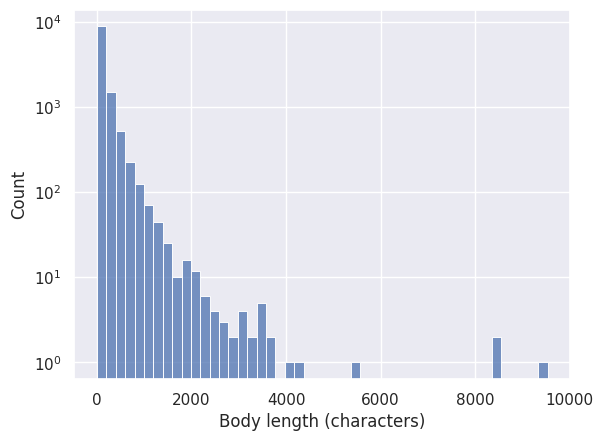

In [16]:
lengths = df[BODY].map(len)
ax = sns.histplot(
    lengths[lengths <= 10000],
    binwidth=200,
    # log_scale=True
)
ax.set(xlabel = "Body length (characters)")
ax.set(yscale = "log");

In [17]:
len(df[lengths >= 10000])

0

In [18]:
# Add a "Time range" column to a dataframe
import datetime

TIME_RANGE = "Time range"
"""Name of the column for storing time range"""

def with_time_range(df):
    dfs = []
    for time_range in config.time_ranges:
        start_time = datetime.datetime.combine(time_range.start_date, datetime.time(0, 0, 0))
        end_time = datetime.datetime.combine(time_range.end_date, datetime.time(0, 0, 0))
        filtered = df[(start_time <= df[TIME]) & (df[TIME] < end_time)].copy()
        filtered[TIME_RANGE] = time_range
        dfs.append(filtered)
    return pd.concat(dfs)

with_time_range(df).head(n=3)

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body,Time range
0,26151741276,2010-01-01 21:35:21,WTF,NaN,26151716521,17754997,6,0,because video games are clearly evil,"TimeRange(start_id=26151671487, end_id=2616049..."
1,26151810869,2010-01-02 19:53:53,funny,6163154.0,26151783720,17767506,5,0,"In this country, due to a crazy statutory syst...","TimeRange(start_id=26151671487, end_id=2616049..."
2,26151877505,2010-01-03 16:50:10,AskReddit,5173746.0,26151775464,17764325,2,0,Another [fun fact](http://en.wikipedia.org/wik...,"TimeRange(start_id=26151671487, end_id=2616049..."


## Graphing distribution over time

<Axes: xlabel='time', ylabel='Count'>

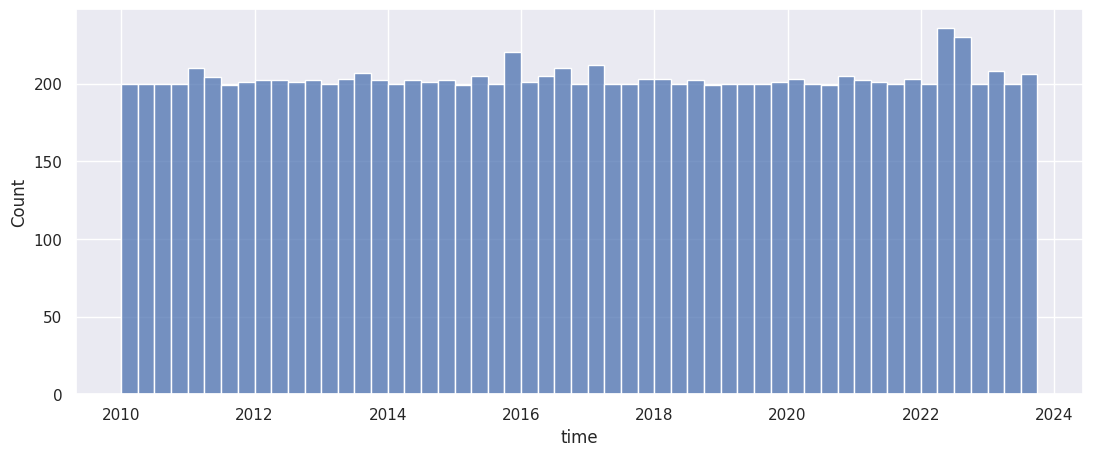

In [19]:
plt.figure(figsize=(13, 5))
sns.histplot(
    data=df,
    x=TIME,
    bins=[
        mpl.dates.date2num(time_range.start_date) for time_range in config.time_ranges
    ],
)

<Axes: xlabel='id', ylabel='hit_rate'>

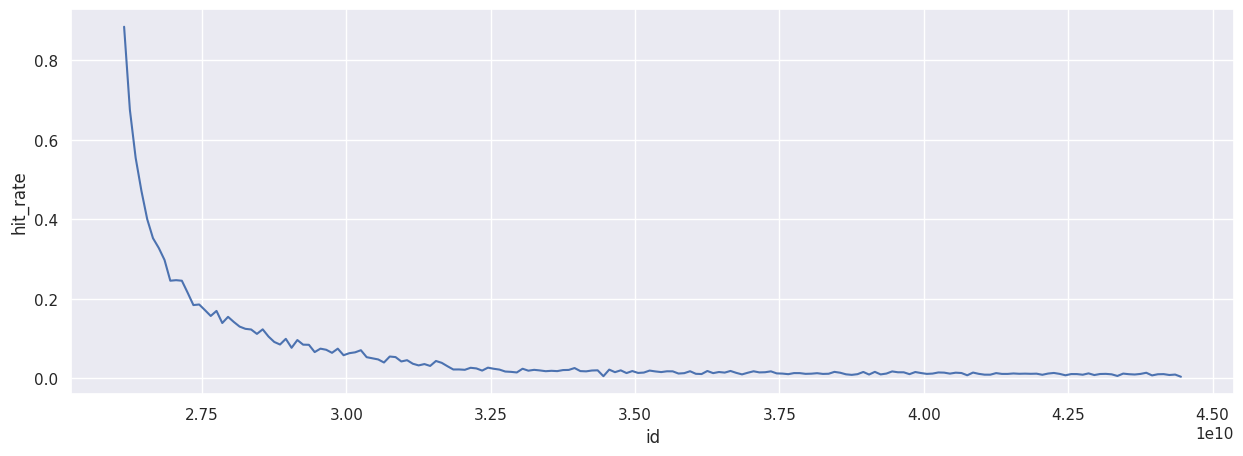

In [20]:
# Hit rates by ID
start = config.time_ranges[0].start_id
end = config.time_ranges[-1].end_id
step = int(1e8)

def get_rate(curr_id):
    next_id = curr_id + step
    num_hits = len(df[(curr_id <= df[ID]) & (df[ID] < next_id)])
    num_misses = len(misses[(misses > start) & (misses < next_id)])

    if num_misses == 0:
        return 0
    return num_hits / (num_hits + num_misses)

ids = np.arange(start, end, step)
rates = np.fromiter(map(get_rate, ids), dtype=np.dtype(np.float64))

rate_df = pd.DataFrame({ "id": ids, "hit_rate": rates })

plt.figure(figsize=(15, 5))
sns.lineplot(data=rate_df, x="id", y="hit_rate")

<Axes: xlabel='Date', ylabel='Hit rate'>

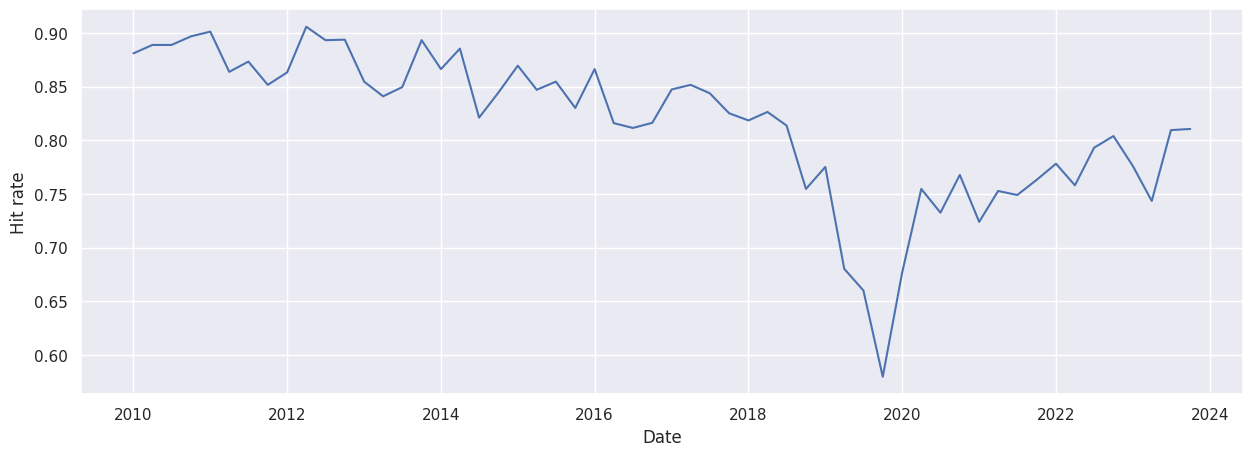

In [21]:
# Approximate hit rate for each time range
ranges = []
for time_range in config.time_ranges:
    num_hits = len(df[(time_range.start_id <= df[ID]) & (df[ID] <= time_range.end_id)])
    num_misses = len(misses[(time_range.start_id <= misses) & (misses <= time_range.end_id)])
    ranges.append([time_range.start_date, num_hits / (num_hits + num_misses)])

data = pd.DataFrame(ranges, columns=["Date", "Hit rate"])
plt.figure(figsize=(15, 5))
sns.lineplot(data, x="Date", y="Hit rate")

<Axes: xlabel='time', ylabel='Count'>

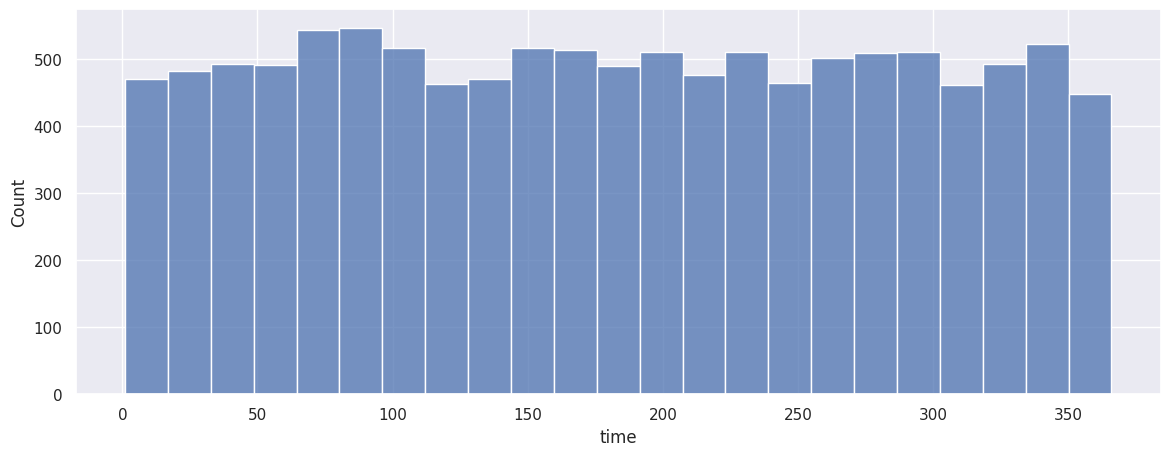

In [22]:
# Number of comments by day of year
plt.figure(figsize=(14, 5))
sns.histplot(data=df[TIME].apply(lambda t: int(t.strftime("%j"))))

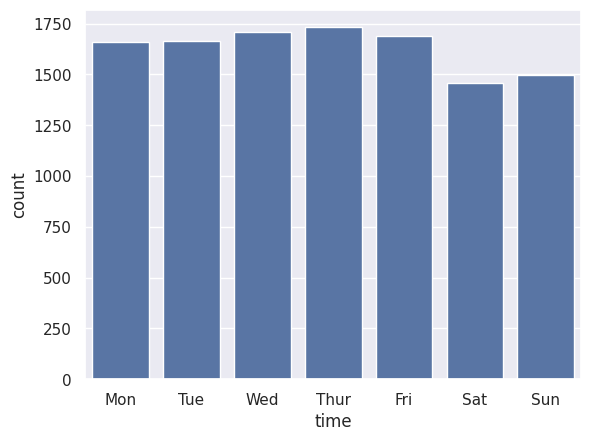

In [23]:
# Number of comments by day of week (0 = Monday)
g = sns.barplot(data=df[TIME].apply(lambda t: t.weekday()).value_counts())
g.set_xticks(
    g.get_xticks(),
    labels=[
        ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"][tick]
        for tick in g.get_xticks()
    ],
);

<Axes: xlabel='id', ylabel='Count'>

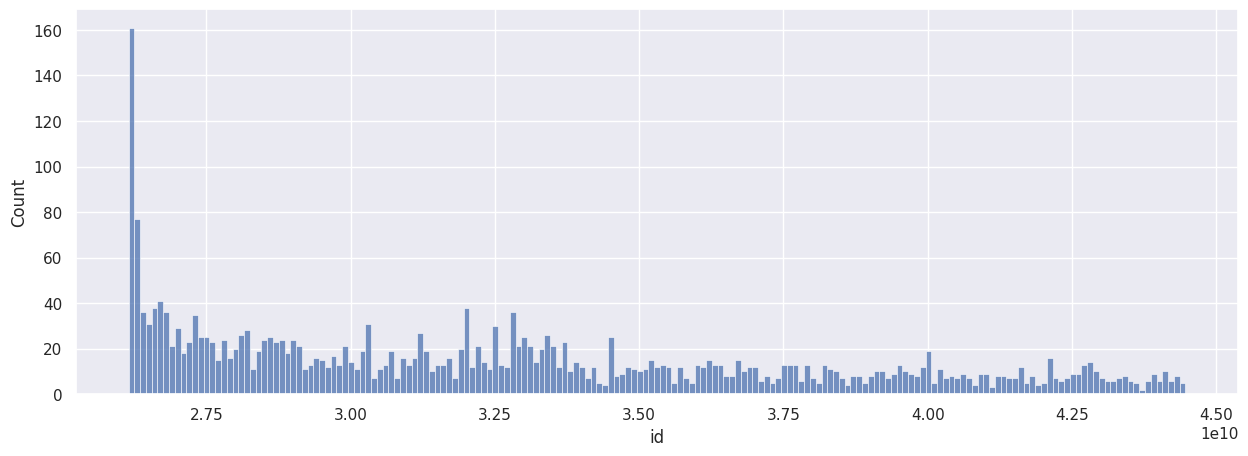

In [24]:
plt.figure(figsize=(15, 5))
misses_actual = misses[misses >= first_id_actual]
sns.histplot(misses_actual, binwidth=1e8)

<Axes: xlabel='id', ylabel='Count'>

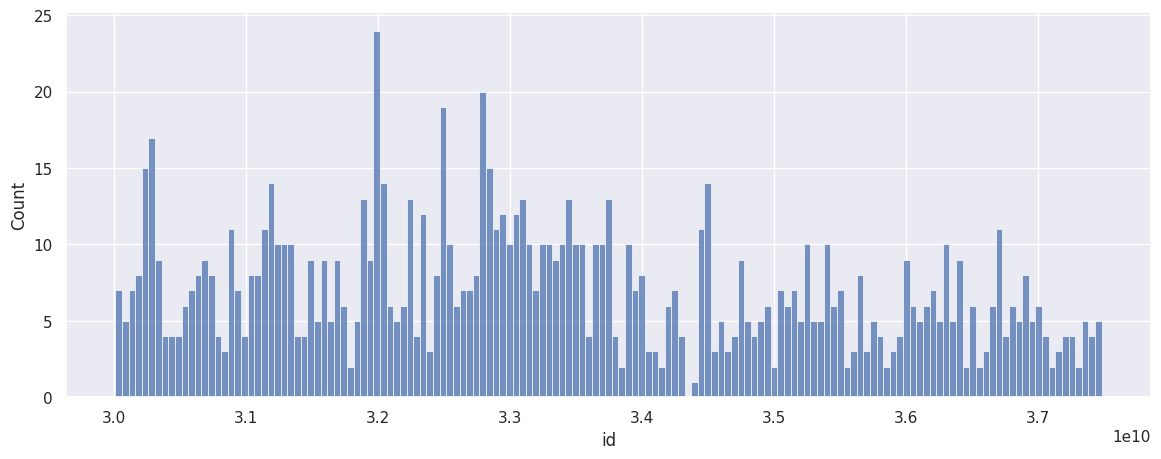

In [25]:
# Zoom in on the middle
# Note: The counts won't match the ones above because the bin width is different

# TODO How are you supposed to filter a series?
weirdos = misses[lambda id: id <= 3.75e10][lambda id: 3e10 <= id]

plt.figure(figsize=(14, 5))
sns.histplot(weirdos, binwidth=5e7)

In [26]:
# What portion of the requests we made actually returned something?
all = len(df) / (len(df) + len(misses))
# Same as above, but don't include requests for comments with IDs that were too low
exclude_invalid = len(df) / (len(df) + len(misses_actual))

all, exclude_invalid

(0.8087234042553192, 0.8087234042553192)

<Axes: xlabel='id', ylabel='rate'>

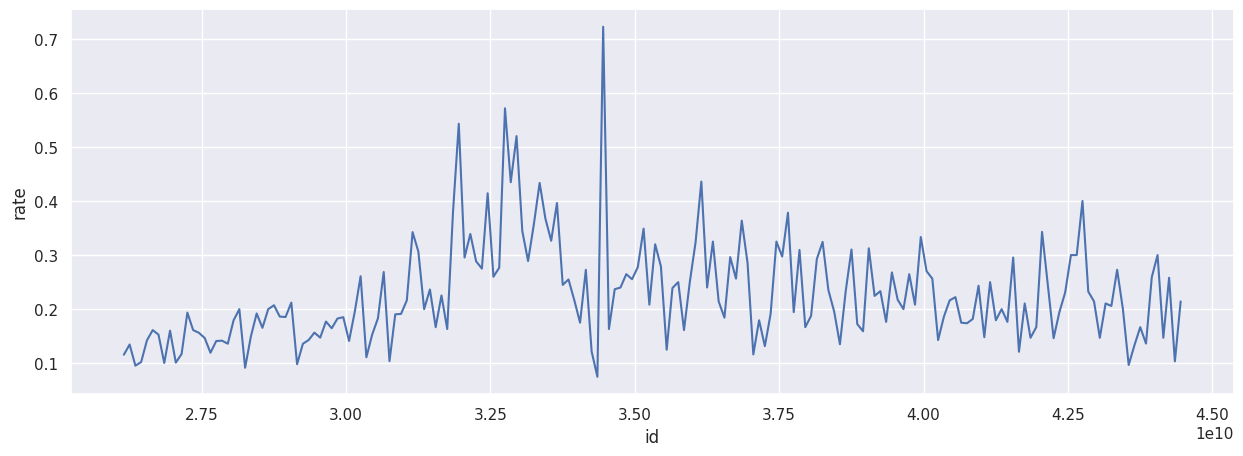

In [27]:
# Hit rate over time
start = first_id_actual
end = max(df.iloc[len(df) - 1][ID],
          misses.loc[len(misses) - 1])
step = int(1e8)

def get_rate(curr_id):
    next_id = curr_id + step
    hits = len(df[(curr_id <= df[ID]) & (df[ID] < next_id)])
    num_misses = len(misses[lambda id: curr_id <= id][lambda id: id < next_id])

    if num_misses == 0:
        return 0
    return num_misses / (hits + num_misses)

ids = np.arange(start, end, step)
rates = np.fromiter(map(get_rate, ids), dtype=np.dtype(np.float64))

rate_df = pd.DataFrame({ "id": ids, "rate": rates })

plt.figure(figsize=(15, 5))
sns.lineplot(data=rate_df, x="id", y="rate")

In [28]:
df[(3e10 <= df[ID]) & (df[ID] < 3.75e10)]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
6498,30004238277,2018-01-05 00:45:36,AskReddit,5.562058e+10,30004206879,463997387,2,0,Not even a little she just munches on trash ev...
6499,30005688527,2018-01-05 14:01:21,BudgetAudiophile,1.751330e+09,2279555301625,464195833,1,0,>Would this preamp make any difference?\n\nIt ...
6500,30007975675,2018-01-06 10:25:26,MTU,7.082428e+07,30007909495,464487250,6,0,"Yeah, I think I'll go with silver then. Thanks..."
6501,30011150155,2018-01-07 13:46:42,VRchat,3.558166e+07,2279555983709,464877917,1,0,"Shaders, I guess\n\nEDIT: Read more here: http..."
6502,30011492512,2018-01-07 15:57:50,Homebrewing,1.435985e+07,30011379025,464751850,1,0,I got it from MoreBeer. I think I'm going to e...
...,...,...,...,...,...,...,...,...,...
9396,37478409873,2021-08-05 12:21:13,polls,3.326688e+11,2280600383610,1509277818,2,0,Different political views lol
9397,37481415274,2021-08-05 19:59:05,tankiejerk,1.030809e+10,37481361297,1509485522,7,0,The farmers introduced communes. He forced the...
9398,37487898772,2021-08-06 16:58:45,CasualUK,6.784617e+11,2280600593325,1509487533,1,0,"They're not, they're just different to what yo..."
9399,37492881026,2021-08-07 11:16:01,arknights,1.501509e+11,2280602293197,1511187405,11,0,Chen is still one of my first go-to operators....


# Subreddits

In [29]:
df[df[SR_NAME] == "reddit.com"]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
27,26153107365,2010-01-16 21:30:58,reddit.com,5723987.0,26153100405,18030394,-11,0,"ha yeah. -43 down votes, thats a record for me..."
28,26153137070,2010-01-17 07:53:18,reddit.com,6401567.0,63326125129,18038857,0,0,Did he say **Alpo** male?\n\nYou shouldn't tea...
69,26155138462,2010-02-06 12:06:28,reddit.com,NaN,63326501884,18415612,3,0,why won't they fix it?
79,26155368926,2010-02-08 23:01:39,reddit.com,5671208.0,63326548999,18462727,7,0,The legacy we've left the next generation. Ne...
87,26155967132,2010-02-15 05:21:24,reddit.com,5885524.0,63326664437,18578165,1,0,This just in: Caffeine wakes you up.
...,...,...,...,...,...,...,...,...,...
1346,26269722665,2011-08-30 15:23:28,reddit.com,9670175.0,63341648273,33562001,1,0,bei Thieme kann man im neuen Online Shop auch ...
1354,26271794790,2011-09-04 23:39:15,reddit.com,6772745.0,26271777548,33801887,7,0,"Your vids are thanks enough.. Wait no, I want ..."
1367,26275345925,2011-09-13 18:14:27,reddit.com,5567304.0,26275163486,34255374,1,0,Hell yes. I started training under the guidanc...
1389,26279433083,2011-09-23 16:04:34,reddit.com,8997053.0,26279428709,34766591,1,0,"hot maybe, cool no :)"


In [30]:
# Most popular subreddits
df[df[SR_NAME] != "reddit.com"][SR_NAME].value_counts().nlargest(20)

sr_name
AskReddit              926
pics                   230
politics               202
funny                  171
gaming                 154
WTF                    133
worldnews              116
leagueoflegends        111
nba                     89
todayilearned           82
IAmA                    82
soccer                  80
videos                  77
trees                   76
atheism                 75
nfl                     66
news                    61
fffffffuuuuuuuuuuuu     61
teenagers               56
SquaredCircle           52
Name: count, dtype: int64

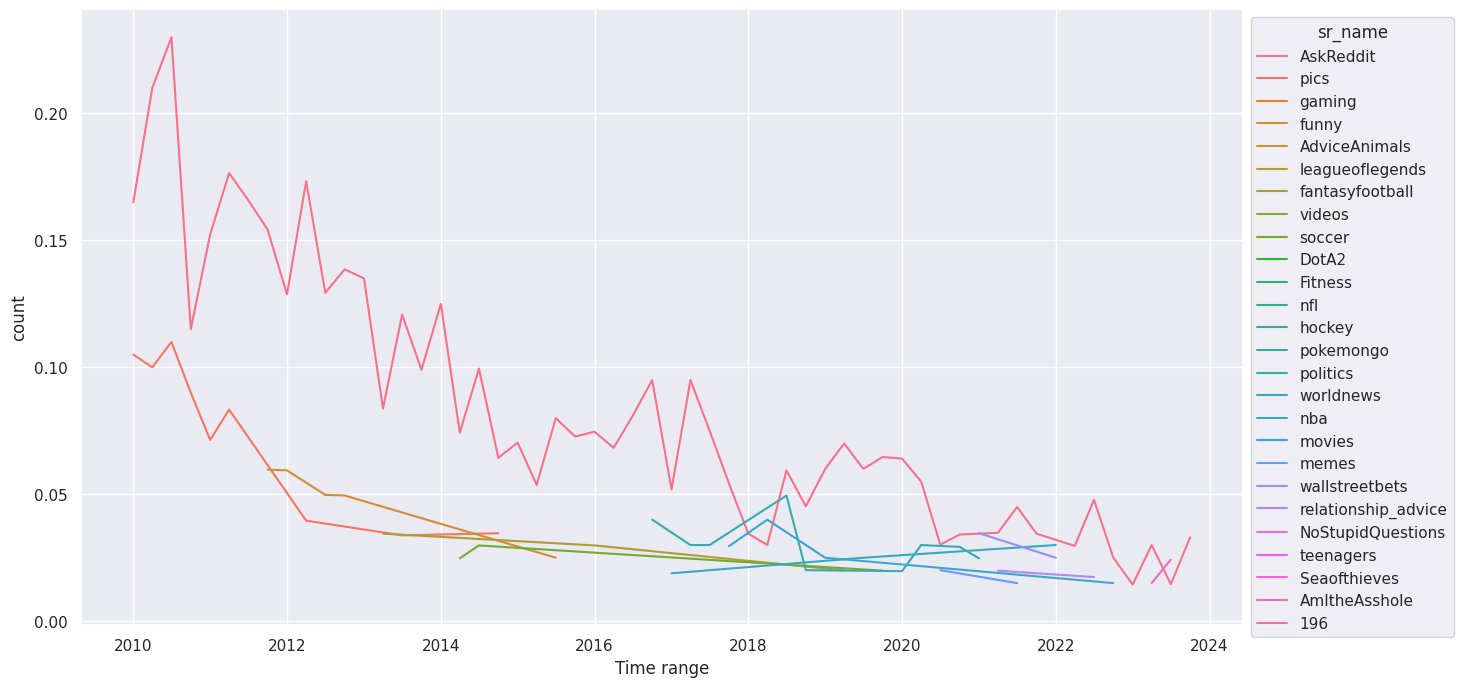

In [42]:
# this looks at *count* rather than percent of comments from each subreddit
# todo fix that (oversampling thing)

data = (
    with_time_range(df)
    .groupby(TIME_RANGE)
    .apply(
        lambda df: df[SR_NAME].value_counts(normalize=True).nlargest(2),
        include_groups=False,
    )
)
data = data.to_frame("count").reset_index()
data[TIME_RANGE] = data[TIME_RANGE].apply(lambda tr: tr.start_date)

plt.figure(figsize=(15, 8))
ax = sns.lineplot(data, x=TIME_RANGE, y="count", hue=SR_NAME)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Text cleaning

In [32]:
# Doing this stuff on all comments is slow, so let's just try it on a small sample
sample_df = pl.from_pandas(df.sample(n=5000, random_state=123).reset_index(drop=True))

In [33]:
# umarkdown and BeautifulSoup let us Markdown
!pip install bs4 umarkdown

/usr/lib/python3.11/pty.py:89: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid, fd = os.forkpty()


In [34]:
from bs4 import BeautifulSoup
from umarkdown import markdown

def parse_markdown(body: str):
    html = markdown(body)
    soup = BeautifulSoup(html, features="html.parser")
    return soup.get_text(" ").strip()

In [35]:
!pip install lingua-language-detector

In [36]:
# Filter out non-English comments
# TODO actually do it

from lingua import Language, LanguageDetectorBuilder

# Most popular languages gotten from
# https://towardsdatascience.com/the-most-popular-languages-on-reddit-analyzed-with-snowflake-and-a-java-udtf-4e58c8ba473c
detector = LanguageDetectorBuilder.from_languages(
    Language.ENGLISH, Language.GERMAN, Language.SPANISH, Language.PORTUGUESE
).build()

text = "spam"

print("Detected language:", detector.detect_language_of(text))
detector.compute_language_confidence_values(text)

Detected language: Language.PORTUGUESE


[ConfidenceValue(language=Language.PORTUGUESE, value=0.37761832674056983),
 ConfidenceValue(language=Language.SPANISH, value=0.2309219807291187),
 ConfidenceValue(language=Language.GERMAN, value=0.20455744953575436),
 ConfidenceValue(language=Language.ENGLISH, value=0.18690224299455727)]

In [37]:
sample_df = sample_df.with_columns(parsed=pl.col(BODY).map_elements(parse_markdown, return_dtype=pl.String))
sample_df

id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body,parsed
i64,datetime[ns],str,f64,i64,i64,i64,i64,str,str
35757348042,2020-12-10 23:37:46,"""EliteNetflix""",5.9666e11,2280318484049,1227378257,2,0,"""Well as someone who doesn't di…","""Well as someone who doesn't di…"
33802837794,2020-02-28 14:09:53,"""wallstreetbets""",3.0358e11,2280016253472,925147680,5,0,"""This isn’t the Great Depressio…","""This isn’t the Great Depressio…"
28065552877,2015-10-19 15:42:26,"""civbattleroyale""",4.2609571e7,28065540616,224006721,18,0,"""Yeah, I find it to be very uni…","""Yeah, I find it to be very uni…"
26420155853,2012-06-08 09:37:06,"""SteamGameSwap""",1.032356e7,26420121154,51650707,1,0,"""It's not unlike The Binding of…","""It's not unlike The Binding of…"
37197834115,2021-06-27 01:27:06,"""nursing""",1.8645e11,37197781118,1465855508,4,0,"""Thank you for your comment! Th…","""Thank you for your comment! Th…"
…,…,…,…,…,…,…,…,…,…
28514951121,2016-05-26 18:41:24,"""Anarcho_Capitalism""",null,28514703954,277418064,5,0,"""http://www.technobuffalo.com/w…","""http://www.technobuffalo.com/w…"
28606992514,2016-07-08 00:36:53,"""photography""",6.444283e6,2279379634080,288528288,2,0,"""The end result was great but b…","""The end result was great but b…"
31243963337,2018-12-28 03:40:19,"""AskOuija""",2.7791114e7,31243942625,621596574,1,0,"""E""","""E"""


In [38]:
from nltk.tokenize.casual import TweetTokenizer
import re
import unicodedata

tokenizer = TweetTokenizer()


def casual_tokenize(text: str) -> str:
    text = unicodedata.normalize("NFKD", text)
    text = re.sub("[uU]/[A-Za-z_-]+", " ", text)
    text = re.sub("[rR]/[A-Za-z_.-]+", " ", text)
    text = text.replace("\n", " ")
    text = text.replace(r"\n", " ")
    # Kind of a dumb way to remove links but I'm like 90% sure it works
    no_links = [
        tok for tok in tokenizer.tokenize(text) if not re.match("https?://", tok)
    ]
    # Remove all tokens that only contain non-word characters
    no_symbol_tokens = [
        tok for tok in tokenizer.tokenize(text) if re.match("[A-Za-z]", tok)
    ]
    return " ".join(no_symbol_tokens)

In [39]:
sample_df.with_columns(tokenized=pl.col(BODY).map_elements(casual_tokenize, return_dtype=pl.String))

id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body,parsed,tokenized
i64,datetime[ns],str,f64,i64,i64,i64,i64,str,str,str
35757348042,2020-12-10 23:37:46,"""EliteNetflix""",5.9666e11,2280318484049,1227378257,2,0,"""Well as someone who doesn't di…","""Well as someone who doesn't di…","""Well as someone who doesn't di…"
33802837794,2020-02-28 14:09:53,"""wallstreetbets""",3.0358e11,2280016253472,925147680,5,0,"""This isn’t the Great Depressio…","""This isn’t the Great Depressio…","""This isn t the Great Depressio…"
28065552877,2015-10-19 15:42:26,"""civbattleroyale""",4.2609571e7,28065540616,224006721,18,0,"""Yeah, I find it to be very uni…","""Yeah, I find it to be very uni…","""Yeah I find it to be very unin…"
26420155853,2012-06-08 09:37:06,"""SteamGameSwap""",1.032356e7,26420121154,51650707,1,0,"""It's not unlike The Binding of…","""It's not unlike The Binding of…","""It's not unlike The Binding of…"
37197834115,2021-06-27 01:27:06,"""nursing""",1.8645e11,37197781118,1465855508,4,0,"""Thank you for your comment! Th…","""Thank you for your comment! Th…","""Thank you for your comment The…"
…,…,…,…,…,…,…,…,…,…,…
28514951121,2016-05-26 18:41:24,"""Anarcho_Capitalism""",null,28514703954,277418064,5,0,"""http://www.technobuffalo.com/w…","""http://www.technobuffalo.com/w…","""http://www.technobuffalo.com/w…"
28606992514,2016-07-08 00:36:53,"""photography""",6.444283e6,2279379634080,288528288,2,0,"""The end result was great but b…","""The end result was great but b…","""The end result was great but b…"
31243963337,2018-12-28 03:40:19,"""AskOuija""",2.7791114e7,31243942625,621596574,1,0,"""E""","""E""","""E"""


In [40]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Uncomment this the first time you run this code block
# nltk.download("wordnet")
# nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = WordNetLemmatizer()

tokens = casual_tokenize("They're going to the mall")
tags = pos_tag(tokens)

def treebank_tag_to_wordnet_tag(tag: str):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# TODO this doesn't handle contractions, use spaCy instead
[lemmatizer.lemmatize(word, treebank_tag_to_wordnet_tag(tag)) for word, tag in tags]

TypeError: tokens: expected a list of strings, got a string

# N-grams

In [42]:
import itertools
import nltk

bigrams = itertools.chain.from_iterable(sample_df["casual_tokenized"].map(nltk.bigrams))
trigrams = itertools.chain.from_iterable(sample_df["casual_tokenized"].map(nltk.trigrams))
fdist = nltk.FreqDist(itertools.chain(bigrams, trigrams))
ngram_df = pd.DataFrame(
    [
        [ngram, fdist[ngram]]
        for ngram in fdist
        if all(isinstance(tok, str) for tok in ngram)
    ],
    columns=["ngram", "freq"],
)
ngram_df

,ngram,freq
0,"(of, the)",482
1,"(in, the)",460
2,"(to, be)",283
3,"(if, you)",242
4,"(on, the)",234
...,...,...
213449,"(legacy, and, vintage)",1
213450,"(and, vintage, shall)",1
213451,"(vintage, shall, continue)",1
213452,"(shall, continue, to)",1


In [43]:
def relevant_ngram(ngram, keywords=keywords):
    for token in ngram:
        for kw in keywords:
            try:
                if kw in token:
                    return True
            except TypeError as e:
                print(kw, ngram)
                raise e
    return False


ngram_df[ngram_df["ngram"].map(lambda ngram: relevant_ngram(ngram, keywords=["anx", "abus"]))].head()

,ngram,freq
12388,"(the, abuse)",2
12389,"(abuse, of)",2
15304,"(an, abusive)",2
18770,"(violence, the, abuse)",2
18771,"(the, abuse, of)",2


# Contextual embeddings

In [38]:
!pip install transformers

In [19]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

/usr/lib/python3.11/pty.py:89: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid, fd = os.forkpty()


Looking in indexes: https://download.pytorch.org/whl/cu118


In [33]:
import torch
from transformers import BertModel, BertTokenizer

# From https://medium.com/@r3d_robot/getting-contextualized-word-embeddings-with-bert-20798d8b43a4
model = BertModel.from_pretrained(
    "bert-base-uncased",
    output_hidden_states=True,
)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


def bert_text_preparation(text, tokenizer):
    """
    Preprocesses text input in a way that BERT can interpret.
    """
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(indexed_tokens)  # convert inputs to tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensor = torch.tensor([segments_ids])
    return tokenized_text, tokens_tensor, segments_tensor


def get_bert_embeddings(tokens_tensor, segments_tensor):
    """
    Obtains BERT embeddings for tokens.
    """
    # gradient calculation id disabled
    with torch.no_grad():
        # obtain hidden states
        outputs = model(tokens_tensor, segments_tensor)
        hidden_states = outputs[2]  # concatenate the tensors for all layers
    # use "stack" to create new dimension in tensor
    token_embeddings = torch.stack(hidden_states, dim=0)
    # remove dimension 1, the "batches"
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    # swap dimensions 0 and 1 so we can loop over tokens
    token_embeddings = token_embeddings.permute(1, 0, 2)
    # intialized list to store embeddings
    token_vecs_sum = []  # "token_embeddings" is a [Y x 12 x 768] tensor
    # where Y is the number of tokens in the sentence    # loop over tokens in sentence
    for token in token_embeddings:  # "token" is a [12 x 768] tensor
        # sum the vectors from the last four layers
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)
    return token_vecs_sum

In [ ]:
sentences = [
    "bank",
    "he eventually sold the shares back to the bank at a premium.",
    "the bank strongly resisted cutting interest rates.",
    "the bank will supply and buy back foreign currency.",
    "the bank is pressing us for repayment of the loan.",
    "the bank left its lending rates unchanged.",
    "the river flowed over the bank.",
    "tall, luxuriant plants grew along the river bank.",
    "his soldiers were arrayed along the river bank.",
    "wild flowers adorned the river bank.",
    "two fox cubs romped playfully on the river bank.",
    "the jewels were kept in a bank vault.",
    "you can stow your jewellery away in the bank.",
    "most of the money was in storage in bank vaults.",
    "the diamonds are shut away in a bank vault somewhere.",
    "thieves broke into the bank vault.",
    "can I bank on your support?",
    "you can bank on him to hand you a reasonable bill for your services.",
    "don't bank on your friends to help you out of trouble.",
    "you can bank on me when you need money.",
    "i bank on your help.",
]

from collections import OrderedDict

context_embeddings = []
context_tokens = []
context_sentences = []

just_trauma = (
    pl_df.lazy()
    .filter(pl.col(BODY).str.contains("trauma"))
    .select(BODY)
    .collect()
    .to_series()
)

for sentence in just_trauma:
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(
        sentence, tokenizer
    )
    # todo handle long sentences
    if tokens_tensor.size(dim=1) > 512:
        continue
    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors)
    # make ordered dictionary to keep track of the position of each   word
    tokens = OrderedDict()
    # loop over tokens in sensitive sentence
    for token in tokenized_text[1:-1]:
        # TODO account for subword tokenization
        if token != "trauma":
            continue
        # keep track of position of word and whether it occurs multiple times
        if token in tokens:
            tokens[token] += 1
        else:
            tokens[token] = 1  # compute the position of the current token
        token_indices = [i for i, t in enumerate(tokenized_text) if t == token]
        current_index = token_indices[
            tokens[token] - 1
        ]  # get the corresponding embedding
        token_vec = list_token_embeddings[current_index]

        # save values
        context_tokens.append(token)
        context_embeddings.append(token_vec)
        context_sentences.append(sentence)

In [43]:
# For visualizing at https://projector.tensorflow.org/

import csv

with open("metadata_output.tsv", "w+") as file_metadata, open(
    "embeddings_small.tsv", "w+"
) as tsvfile:
    writer = csv.writer(tsvfile, delimiter="\t")
    for token, embedding, sentence in zip(
        context_tokens, context_embeddings, context_sentences
    ):
        if token != "trauma":
            continue
        file_metadata.write(sentence + "\n")
        writer.writerow(embedding.numpy())

In [71]:
# Clustering
from sklearn.cluster import *

trauma_embeddings_with_inds = [
    (i, embedding)
    for i, embedding in enumerate(context_embeddings)
    if context_tokens[i] == "trauma"
]
trauma_embeddings = [embedding for i, embedding in trauma_embeddings_with_inds]

# clustering = DBSCAN(eps=0.01, min_samples=2).fit(trauma_embeddings)
# clustering = HDBSCAN(min_cluster_size=5).fit(trauma_embeddings)
# clustering = OPTICS().fit(trauma_embeddings)
# clustering = KMeans().fit(trauma_embeddings)
clustering = AffinityPropagation(verbose=True).fit(trauma_embeddings)
pd.Series(clustering.labels_).value_counts()

Converged after 27 iterations.


44    45
9     38
22    33
10    31
4     29
21    24
35    23
18    23
31    22
37    21
17    20
29    18
7     18
6     18
26    18
28    16
15    16
32    16
23    15
40    14
8     14
49    14
38    13
41    13
27    13
34    12
16    11
46    11
11    10
20    10
3     10
1     10
45    10
2      8
13     8
5      8
25     7
39     7
30     6
0      6
47     5
19     5
48     5
24     4
14     4
42     4
12     4
33     3
43     3
36     2
Name: count, dtype: int64

In [66]:
# For visualizing at https://projector.tensorflow.org/

import csv

with open("metadata_output.tsv", "w+") as file_metadata, open(
    "embeddings_small.tsv", "w+"
) as tsvfile:
    file_metadata.write("Sentence\tCluster\n")
    writer = csv.writer(tsvfile, delimiter="\t")
    for (i, embedding), cluster in zip(trauma_embeddings_with_inds, clustering.labels_):
        token = context_tokens[i]
        sentence = context_sentences[i]
        if token != "trauma":
            continue
        file_metadata.write(f"{sentence}\t{cluster}\n")
        writer.writerow(embedding.numpy())